**Remark**

It is possible to compare a Random Forest, Regression Tree, and an XGBoost model. The choice of the evaluation metric will depend on the specific problem and the goals of the model. Some commonly used evaluation metrics for regression models include:

- Mean Squared Error (MSE),  
- Mean Absolute Error (MAE), 
- R-squared (R²), 
- Median Absolute Error (MedAE),
- Mean Squared Log Error (MSLE).

If the goal is to minimize the prediction error, then MAE, MSE or RMSE could be used. 
On the other hand, if the goal is to have a more interpretable model, then the simpler models such as Regression Tree could be compared using the R² metric.

Therefore, the evaluation function should be chosen based on the problem and the goals of the model.

In [3]:
!pip install rdkit
!pip install bayesian-optimization
!pip install scikit-optimize

In [18]:
import xgboost as  xgb
import sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, log_loss
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm.notebook import tqdm
#from google.colab import drive
import math
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
import os
import joblib
from dataframe_pipeline_script import Dataset
#drive.mount('/content/drive')

In [8]:
#path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
path = "DATA/fingerprint_df.csv"
df = pd.read_csv(path)
df.head()

,index,Unnamed: 0.1,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,...,fp122,fp123,fp124,fp125,fp126,fp127,fp128,binary_rat_ld50,LD50_level,LD50_rat_level
0,0,0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734.0,As,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
1,1,1,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338.0,C2H3Cl,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,2,2,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241.0,C6H6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
3,3,3,5,8,T3D0007,Cadmium,Cadmium (group IIB of the periodic table of el...,7440-43-9,31193.0,Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,4,5,9,13,T3D0012,Clofenotane,Insecticide. Clofenotane is a major component ...,50-29-3,3036.0,C14H9Cl5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [10]:
trainset = Dataset(data=df, label="LD50_rat_level", representation="finger", purpose="train", shuffle=False, qed=True, tensor=False)
X_train, t_train = trainset.make()


Train


C:\Users\pietr\My Drive\Toxicity Project\dataframe_pipeline_script.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["index"] = list(range(len(self.data)))


ignored: 0
Largest value: 667.869
Number of unique embedding values: 618
x shape: (394, 137)
t shape: (394,)


In [11]:
valset = Dataset(data=df, label="LD50_rat_level", representation="finger", purpose="val", shuffle=False, qed=True, tensor=False)
X_val, t_val = valset.make()


Val
ignored: 1
Largest value: 631.5709999999999
Number of unique embedding values: 611
x shape: (169, 137)
t shape: (169,)


[20:11:57] Explicit valence for atom # 0 O, 3, is greater than permitted


(array([76.,  0.,  0.,  0.,  0., 27.,  0.,  0.,  0., 66.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

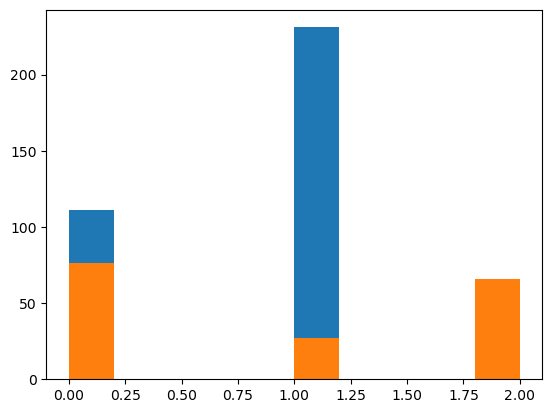

In [12]:
plt.hist(t_train)
plt.hist(t_val)

In [13]:
#========Setting up a confusion matrix=============

def confusion_matrix(y_true, y_pred):
    """
    Calculate the confusion matrix for a multi-class classification task with 3 classes.
    
    Parameters:
    y_true: 1D array of integers representing the true labels
    y_pred: 1D array of integers representing the predicted labels
    
    Returns:
    Confusion matrix (2D array of integers)
    """
    # initialize the confusion matrix
    cm = np.zeros((3, 3))
    
    # populate the confusion matrix
    for true_label, pred_label in zip(y_true, y_pred):
        cm[pred_label,true_label] += 1

    cm_norm = cm.copy()
    print(cm_norm)
    for i in range(len(cm_norm)):
        cm_norm[:,i] = cm_norm[:,i]/sum(cm_norm[:,i])
    print(cm_norm)
    plt.figure()
    plt.imshow(cm_norm)
    # add the numbers to the plot squares
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i, j]:0.3f}", ha='center', va='center')
    plt.locator_params(nbins=4)
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    plt.show()

    plt.figure()
    plt.imshow(cm)
    # add the numbers to the plot squares
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.locator_params(nbins=4)
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    plt.show()

    return cm, cm_norm

In [15]:
#===========================XGBoost Regressor with Bayesian hyperparameter optimization===========================$

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=int(max_depth),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        silent=1,
        objective='reg:squarederror'
    )
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_squared_error', cv=5)
    return cval.mean()

def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            'n_estimators': (1, 250),
            'max_depth': (1, 30),
            'gamma': (0.001, 1.0),
            'min_child_weight': (0.1, 10.0),
            'subsample': (0.4, 1.0)
        },
        random_state=1234,
        verbose=1
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max

best = optimize_xgb(X_train, t_train)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
[20:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:05] WARNING: C:\buildkite-agent\build

[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

| 9         | -0.4046   | 1.0       | 11.85     | 5.858     | 202.4     | 1.0       |
[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:13:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-win

Performance XGB Regressor:
Mean Absolute Error: 0.7514792899408284 mg/kg
Benchmark: 0.8461888589335108 mg/kg
R^2: -0.5345635618043354
[[59. 22. 35.]
 [ 7.  3.  6.]
 [10.  2. 25.]]
[[0.77631579 0.81481481 0.53030303]
 [0.09210526 0.11111111 0.09090909]
 [0.13157895 0.07407407 0.37878788]]


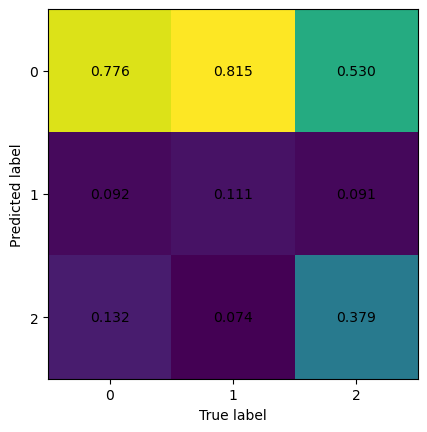

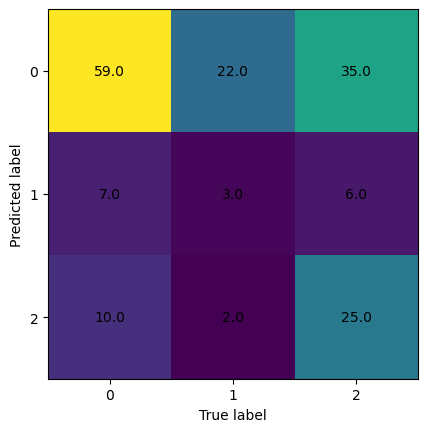

In [21]:
#=======XGBoost Regressor fit===========

XGBreg = xgb.XGBClassifier(eval_metric='rmsle')
XGBreg=xgb.XGBClassifier(learning_rate = 0.1,
                           gamma = best["params"]["gamma"],
                           min_child_weight = int(best["params"]["min_child_weight"]),
                           n_estimators = int(best["params"]["n_estimators"]),
                           max_depth = int(best["params"]["max_depth"]),
                           subsample = best["params"]["subsample"],
                           eval_metric='rmsle')

XGBreg.fit(X_train, t_train)
XGBreg.score(X_val, t_val)
xg_pred = XGBreg.predict(X_val)

mae = sklearn.metrics.mean_absolute_error(t_val,xg_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, xg_pred)

print("Performance XGB Regressor:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

cm, cm_norm = confusion_matrix(t_val.astype(int), xg_pred.astype(int))

#joblib.dump(XGBreg,"/content/drive/My Drive/Toxicity Project/Saved_models/XGB_Classifier.joblib")

In [22]:
#==========Evaluation functions XGBoost================



#mse 
mse = sklearn.metrics.mean_squared_error(t_val, xg_pred)
#R2
r2 = sklearn.metrics.r2_score(t_val, xg_pred)
#Mean absolute error 
mae = sklearn.metrics.mean_absolute_error(t_val, xg_pred)
#median absolute error 
medae = sklearn.metrics.median_absolute_error(t_val, xg_pred)
#mse log error 
#msle = sklearn.metrics.mean_squared_log_error(t_val, xg_pred)

print("Mean squared error:", mse)
print("R-squared score:", r2)
print("Mean absolute error:", mae)
print("Median absolute error:", medae)
#print("Mean squared logarithmic error:", msle)

Mean squared error: 1.2840236686390532
R-squared score: -0.5345635618043354
Mean absolute error: 0.7514792899408284
Median absolute error: 0.0


CCELoss = 20.232774337847086
Performance XGB Regressor:
Mean Absolute Error: 0.8402366863905325 mg/kg
Benchmark: 0.8461888589335108 mg/kg
R^2: -0.6123524981169974
[[39. 12. 26.]
 [20.  4. 13.]
 [17. 11. 27.]]
[[0.51315789 0.44444444 0.39393939]
 [0.26315789 0.14814815 0.1969697 ]
 [0.22368421 0.40740741 0.40909091]]


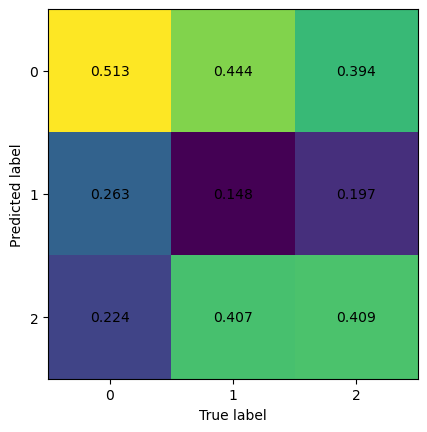

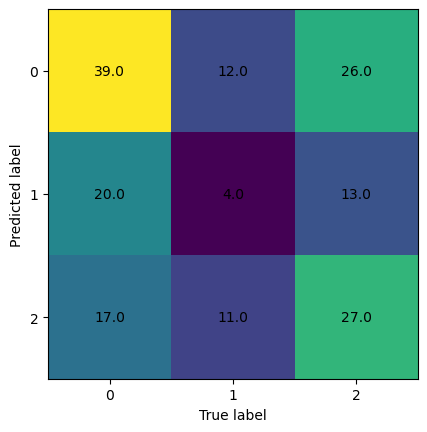

In [27]:
#======Classification Tree=============



dec_tree = DecisionTreeClassifier(criterion="gini")
dec_tree.fit(X_train, t_train)
dt_pred = dec_tree.predict(X_val)

cce = log_loss(t_val,np.eye(3)[dt_pred.astype(int)])
print(f"CCELoss = {cce}")

mae = sklearn.metrics.mean_absolute_error(t_val,dt_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, dt_pred)

print("Performance XGB Regressor:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

cm, cm_norm = confusion_matrix(t_val.astype(int), dt_pred.astype(int))

# add labels and title
#plt.ylabel('Predicted label')
#plt.xlabel('True label')
#plot_tree(reg_tree, filled=True, feature_names=df.columns[:-1], rounded=True, fontsize=10)
#plt.show()

#joblib.dump(dec_tree,"/content/drive/My Drive/Toxicity Project/Saved_models/Classification_Tree.joblib")

In [ ]:
#==========Evaluation functions regression tree================

#mse 
tmse = sklearn.metrics.mean_squared_error(t_val, dt_pred)
#R2
tr2 = sklearn.metrics.r2_score(t_val, dt_pred)
#Mean absolute error 
tmae = sklearn.metrics.mean_absolute_error(t_val, dt_pred)
#median absolute error 
tmedae = sklearn.metrics.median_absolute_error(t_val, dt_pred)
#mse log error 
tmsle = sklearn.metrics.mean_squared_log_error(t_val, dt_pred)

print("Mean squared error:", tmse)

print("R-squared score:", tr2)
print("Mean absolute error:", tmae)
print("Median absolute error:", tmedae)
print("Mean squared logarithmic error:", tmsle)

Mean squared error: 1.6449704142011834
R-squared score: -0.9659385722654619
Mean absolute error: 0.9349112426035503
Median absolute error: 1.0
Mean squared logarithmic error: 0.508481575605154


CCELoss = 20.232774337847086
Performance XGB Regressor:
Mean Absolute Error: 0.893491124260355 mg/kg
Benchmark: 0.8461888589335108 mg/kg
R^2: -0.9164365218846768
[[67. 26. 53.]
 [ 2.  0.  2.]
 [ 7.  1. 11.]]
[[0.88157895 0.96296296 0.8030303 ]
 [0.02631579 0.         0.03030303]
 [0.09210526 0.03703704 0.16666667]]


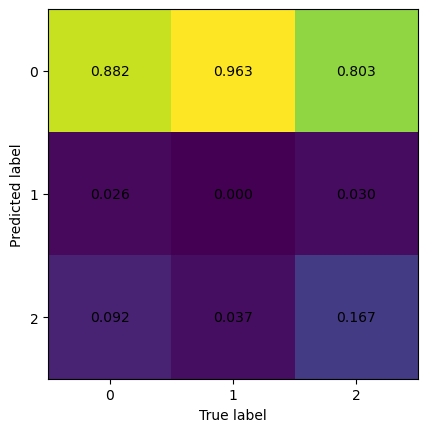

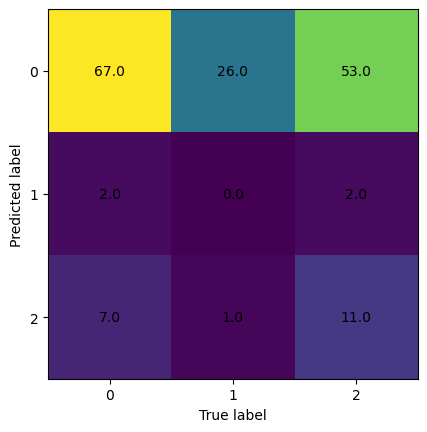

In [30]:
#=======Random Forest Classifier=============

from sklearn.ensemble import RandomForestClassifier

dec_forest = RandomForestClassifier(criterion="gini")
dec_forest.fit(X_train, t_train)
rf_pred = dec_forest.predict(X_val)

cce = log_loss(t_val,np.eye(3)[dt_pred.astype(int)])
print(f"CCELoss = {cce}")

mae = sklearn.metrics.mean_absolute_error(t_val, rf_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, rf_pred)

print("Performance XGB Regressor:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

cm, cm_norm = confusion_matrix(t_val.astype(int), rf_pred.astype(int))

#plt.ylabel('Predicted label')
#plt.xlabel('True label')

#joblib.dump(dec_forest,"/content/drive/My Drive/Toxicity Project/Saved_models/RandomForest_Classifier.joblib")

In [ ]:
#==========Evaluation functions random forest================

#mse 
rfmse = sklearn.metrics.mean_squared_error(t_val, rf_pred)
#R2
rfr2 = sklearn.metrics.r2_score(t_val, rf_pred)
#Mean absolute error 
rfmae = sklearn.metrics.mean_absolute_error(t_val, rf_pred)
#median absolute error 
rfmedae = sklearn.metrics.median_absolute_error(t_val, rf_pred)
#mse log error 
rfmsle = sklearn.metrics.mean_squared_log_error(t_val, rf_pred)

print("Mean squared error:", rfmse)
print("R-squared score:", rfr2)
print("Mean absolute error:", rfmae)
print("Median absolute error:", rfmedae)
print("Mean squared logarithmic error:", rfmsle)

Mean squared error: 1.4437869822485208
R-squared score: -0.7255000418445061
Mean absolute error: 0.8165680473372781
Median absolute error: 1.0
Mean squared logarithmic error: 0.46013334951671064


**Anova**

The following Anova table only confirms that the three different models are statistically different.

In [ ]:
#=======ANOVA implementation=========

import statsmodels.api as sm

#Compute residuals
xgb_resid = t_val - xg_pred
rt_resid = t_val - dt_pred
rf_resid =  t_val - rf_pred

# Create dataframe of residuals 
resid_df = df = pd.DataFrame({"xgb_resid": xgb_resid, "rt_resid": rt_resid, "rf_resid": rf_resid})

# Create ANOVA table
anova_model = ols('xgb_resid ~ rt_resid + rf_resid', data=resid_df).fit()

# Print ANOVA table
print(sm.stats.anova_lm(anova_model, typ=2))


              sum_sq     df          F        PR(>F)
rt_resid   12.347796    1.0  15.382365  1.282775e-04
rf_resid   29.860265    1.0  37.198664  7.254488e-09
Residual  133.252204  166.0        NaN           NaN
